In [ ]:
!pip install --upgrade pip
%pip install evaluate
!pip install transformers
!pip install datasets
!pip install --upgrade notebook
!pip install --upgrade ipywidgets
!pip install matplotlib
!pip install pandas

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, Seq2SeqTrainingArguments, Seq2SeqTrainer, AutoConfig
from transformers import RobertaTokenizer, T5ForConditionalGeneration
import time
# import evalute
import pandas as pd
import numpy as np
# from .autonotebook import tqdm as notebook_tqdm

In [ ]:
# import tarfile
# tar1 = tarfile.open("./methods2test/corpus/raw/fm/train.tar.bz2", "r:bz2")
# tar1.extractall()
# tar1.close()

In [ ]:
# import tarfile
# tar2 = tarfile.open("./methods2test/corpus/raw/fm/test.tar.bz2", "r:bz2")
# tar2.extractall()
# tar2.close()

In [ ]:
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torch

torch.cuda.is_available()
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:")
torch.cuda.current_device()
	
print(f"Name of current CUDA device:")
torch.cuda.get_device_name(cuda_id)


In [ ]:
# test tensor
x = torch.randint(1, 100, (100, 100))
print(x.device)

res_cpu = x ** 2
x = x.to(torch.device('cuda'))
print(x.device)
 
# Applying same tensor operation
res_gpu = x ** 2
assert torch.equal(res_cpu, res_gpu.cpu())

In [ ]:
import pandas as pd
train_csv = pd.read_csv("C:/Users/DIAL/Desktop/Jahid/train_csv.csv")

In [ ]:
train_csv

In [ ]:
import pandas as pd
test_csv = pd.read_csv("C:/Users/DIAL/Desktop/Jahid/test_csv.csv")

In [ ]:
test_csv

In [ ]:
test_csv.to_csv("test_csv.csv", index=False)
train_csv.to_csv("train_csv.csv", index=False)

In [ ]:
dataset = load_dataset('csv', data_files={'train': "train_csv.csv", 'test': "test_csv.csv"})

In [ ]:
dataset

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("Salesforce/codet5-base")

In [ ]:
from transformers import RobertaTokenizer, T5ForConditionalGeneration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base').to(device)

In [ ]:
model

In [ ]:
def tokenize_function(example):

  start_prompt = 'Generate testcase of the following text_method:\n'
  end_prompt = '\nTest Case: '
  prompt = [start_prompt + text + end_prompt for text in example['Input']]
  example['input_ids'] = tokenizer(prompt, max_length=512, truncation=True, padding='max_length', return_tensors="pt").input_ids
  example['labels'] = tokenizer(example['Output'], max_length=512, truncation=True, padding='max_length', return_tensors="pt").input_ids

  return example

tokenized_dataset = dataset.map(tokenize_function, batched=True)  
tokenized_dataset = tokenized_dataset.remove_columns(['Input','Output'])


# tokenized_dataset_test = test.map(tokenize_function, batched=True)
# tokenized_dataset_test = tokenized_dataset_test.remove_columns(['text',])

print(f"Shapes of the datasets:")
print(f"Training: {tokenized_dataset['train'].shape}")
print(f"Test: {tokenized_dataset['test'].shape}")
#print(f"Validation: {tokenized_datasets['validation'].shape}")

In [ ]:
#Calculating Rouge Score

In [ ]:
import evaluate
import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer

from nltk.tokenize import sent_tokenize

rouge_metric = evaluate.load("rouge")

# Function for custom tokenization
def tokenize_sentence(arg):
  encoded_arg = tokenizer(arg)
  return tokenizer.convert_ids_to_tokens(encoded_arg.input_ids)

# Function to get ROUGE scores with custom tokenization
def metrics_func(eval_arg):
  preds, labels = eval_arg
  ("Prediction: ", preds.shape)
  ("Label: ", labels.shape)
  preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
  ("Prediction: ", preds.shape)
  ("Label: ", labels.shape)

  text_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
  text_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  (text_labels)
  (text_preds)
  #text_preds = [tokenizer.decode(pred, skip_special_tokens=True) for pred in preds]

  text_preds = ["\n".join(sent_tokenize(p)) for p in text_preds]
  text_labels = ["\n".join(sent_tokenize(l)) for l in text_labels]

  return rouge_metric.compute(
    predictions=text_preds,
    references=text_labels,
    tokenizer=tokenize_sentence
  )

# Calculating evalutation score: Code Bert Score

In [1]:
!pip install code_bert_score

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaModel
from torch.nn.functional import cosine_similarity

codebert_tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
codebert_model = RobertaModel.from_pretrained("microsoft/codebert-base").to('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Tokenization Function
def decode_texts(texts, tokenizer):
    return [tokenizer.decode(tokenizer.encode(text, truncation=True, padding=True), skip_special_tokens=True) for text in texts]

# Function to Compute Cosine Similarity between embeddings
def compute_similarity(embeddings1, embeddings2):
    return cosine_similarity(embeddings1, embeddings2, dim=1).mean().item()

# Custom function to compute CodeBERT-based similarity scores
def compute_codebertscore(predictions, labels, reference_texts):
    
    # Tokenize and get embeddings from CodeBERT
    inputs_pred = codebert_tokenizer(predictions, return_tensors="pt", padding=True, truncation=True).to(codebert_model.device)
    inputs_labels = codebert_tokenizer(labels, return_tensors="pt", padding=True, truncation=True).to(codebert_model.device)
    inputs_ref = codebert_tokenizer(reference_texts, return_tensors="pt", padding=True, truncation=True).to(codebert_model.device)

    with torch.no_grad():
        pred_embeddings = codebert_model(**inputs_pred).last_hidden_state.mean(dim=1)  # Get sentence embeddings
        label_embeddings = codebert_model(**inputs_labels).last_hidden_state.mean(dim=1)  # Get sentence embeddings
        ref_embeddings = codebert_model(**inputs_ref).last_hidden_state.mean(dim=1)  # Get reference embeddings

    precision = compute_similarity(pred_embeddings, label_embeddings)
    recall = compute_similarity(pred_embeddings, ref_embeddings)  # Similarity to reference
    f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Metric Calculation Function
def metrics_func01(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Replace with actual reference text
    reference_texts = ["example reference text from your dataset"] * len(decoded_preds)  # Adjust as needed
    
    codebertscore = compute_codebertscore(decoded_preds, decoded_labels, reference_texts)
    return codebertscore

# Calculating ChrF Score

In [ ]:
import evaluate
import nltk
import numpy as np
#nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

chrf_metric = evaluate.load("chrf")

def tokenize_sentence(arg):
    encoded_arg = tokenizer(arg)
    return tokenizer.convert_ids_to_tokens(encoded_arg.input_ids)

def metrics_func_chrf(eval_arg):
    preds, labels = eval_arg
    print("Prediction shape:", preds.shape)
    print("Label shape:", labels.shape)
    
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    print("Updated Prediction shape:", preds.shape)
    print("Updated Label shape:", labels.shape)
    
    text_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    text_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    print("Decoded Labels:", text_labels)
    print("Decoded Predictions:", text_preds)
    
    text_preds = ["\n".join(sent_tokenize(p)) for p in text_preds]
    text_labels = ["\n".join(sent_tokenize(l)) for l in text_labels]
    
    chrf_scores = chrf_metric.compute(
        predictions=text_preds,
        references=text_labels,
        word_order=2
    )
    
    return chrf_scores

# Training Arguments

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
  log_level = "error",
  logging_strategy = "steps",
  logging_steps = 500,
  fp16=True,
  disable_tqdm = False,
  max_steps = 10,
  learning_rate = 5e-5,
  #1e-3,3e-6,#5e-5,
  warmup_steps = 100,
  optim="adamw_torch",
  #optim="adamw_hf",
  #optim="adamw_apex_fused",
  weight_decay = 0.01,
  per_device_train_batch_size = 4,
  per_device_eval_batch_size = 32,
  gradient_accumulation_steps = 16,
  eval_delay =0,
  max_grad_norm = 1,
  lr_scheduler_type = "cosine",
  predict_with_generate=True,
  generation_max_length = 512,
  eval_strategy = "steps",
  eval_steps = 2,
  save_strategy = "steps",
  save_steps = 2,
  output_dir = "Methods2TestCase-GenerationTest",
  overwrite_output_dir = True,
  save_total_limit=3,
  load_best_model_at_end=True,
  #num_train_epochs = 3,
  #use_cpu = False,
  # generation_config=GenerationConfig(max_new_tokens=1024, do_sample=True, top_k=50, top_p=1.0, 
  #                                    typical_p=1.0, temperature=1, use_cache=True, output_attentions=True),
  #gradient_checkpointing=True,  
  #auto_find_batch_size = True,
  #correct_bias = True,  
  # save_total_limit = 3,
  # load_best_model_at_end = True,
  #remove_unused_columns = True,
  # optimizer = torch.optim.adamw_hf(model.parameters(), weight_decay = 0.01, correct_bias = True, lr=1e-3),
  # lambda1 = lambda epoch: epoch / 10,
  # scheduler = lr_scheduler.LambdaLR(optimizer, lambda1),
  push_to_hub = False
)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    max_length=512,
    return_tensors="pt"
)

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(

  model = model,
  args = training_args,
  data_collator = data_collator,

  train_dataset = tokenized_dataset['train'].select(range(50)),
  eval_dataset = tokenized_dataset['test'].select(range(10)),
  
  tokenizer = tokenizer,
  compute_metrics = metrics_func_chrf,
    
)

trainer.train()

In [ ]:
import os

save_dir = "C:/Users/DIAL/Desktop/Jahid/Fine-Tuned_model"
os.makedirs(save_dir, exist_ok=True)

# save training log
log_df = pd.DataFrame(trainer.state.log_history)
log_df.to_csv(os.path.join(save_dir, 'training_log.csv'))

if hasattr(trainer.model, "module"):
  trainer.model.module.save_pretrained(save_dir)
else:
  trainer.model.save_pretrained(save_dir)


In [ ]:
 import os
 from transformers import AutoConfig

 load_dir = 'C:/Users/DIAL/Desktop/Jahid/Fine-Tuned_model'
 device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 codet5_config = AutoConfig.from_pretrained(
   load_dir,
   output_attentions = True,
   generation_max_length=512,
 )

 model = AutoModelForSeq2SeqLM.from_pretrained(load_dir, config=codet5_config).to(device)
 df = pd.read_csv(os.path.join(load_dir, 'training_log.csv'))


In [ ]:
import os
cwd = os.getcwd()
files = os.listdir(cwd)
print("Files in %r: %s" % (cwd, files))

In [ ]:
df_eval = df[[
    'epoch',
    'step',
    'eval_loss',
    'eval_rouge1',
    'eval_rouge2',
    'eval_rougeL',
    'eval_rougeLsum',
    ]].dropna()
df_eval

# Rouge Score Prediction for the trained model

In [ ]:
from torch.utils.data import DataLoader

sample_dataloader = DataLoader(

  tokenized_dataset["test"].with_format("torch"),
  collate_fn = data_collator,
  batch_size = 10)

for batch in sample_dataloader:
  with torch.no_grad():

    preds = model.generate(
        batch["input_ids"].to('cuda'),
        remove_invalid_values=True,
        generation_config=GenerationConfig(max_new_tokens=512, do_sample=True, top_k=50, top_p=1.0,
                                           typical_p=1.0, temperature=1.5, use_cache=True, output_attentions=True),
        length_penalty=1.0,
        no_repeat_ngram_size=2,
        num_return_sequences=1,
    )

  labels = batch["labels"]
  break
preds = preds.to('cpu')
metrics_func([preds, labels])


# Ploting Graphs

In [ ]:
from  matplotlib import pyplot as plt

In [ ]:
df_loss = df['loss']
df_loss = df_loss.dropna()
df_loss

In [ ]:
df_step = df['step']
df_step = df_step[~df_step.duplicated(keep='first')]
df_step

In [ ]:
import os
import matplotlib.pyplot as plt

df_clean = df.dropna(subset=['step', 'loss'])

df_step = df_clean['step']
df_loss = df_clean['loss']

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(df_step, df_loss)
plt.legend(['Training Loss'], loc='upper right', fontsize='14')
plt.xlabel('Steps', fontsize='14')
plt.ylabel('Loss', fontsize='14')
plt.show()

#save the figure
fig = ax.get_figure()
fig.savefig(os.path.join(load_dir, 'training_loss.png'), bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(df_eval['step'], df_eval['eval_loss'], color='green')
plt.legend(['Validation Loss'], loc='upper right', fontsize='14')
plt.xlabel('Steps', fontsize='14')
plt.ylabel('Loss', fontsize='14')
plt.show()

fig = ax.get_figure()
fig.savefig(os.path.join(load_dir, 'validation_loss.png'), bbox_inches='tight')

# Graphs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_folder = 'C:/Users/DIAL/Desktop/Jahid/Methods2TestCase-Generation/checkpoint-1000'
model = T5ForConditionalGeneration.from_pretrained(checkpoint_folder).to(device)
tokenizer = RobertaTokenizer.from_pretrained("Salesforce/codet5-base")

In [ ]:
pip install matplotlib seaborn pandas numpy

In [23]:
import json
import matplotlib.pyplot as plt
trainer_state_path = 'C:/Users/DIAL/Desktop/Jahid/Methods2TestCase-GenerationNew/checkpoint-1200/trainer_state.json'

with open(trainer_state_path, 'r') as f:
    trainer_state = json.load(f)

log_history = trainer_state['log_history']

# Lists to store metrics
steps = []
eval_losses = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
rougeLsum_scores = []

for log in log_history:
    if 'eval_loss' in log:
        steps.append(log['step'])
        eval_losses.append(log['eval_loss'])
        rouge1_scores.append(log['eval_rouge1'])
        rouge2_scores.append(log['eval_rouge2'])
        rougeL_scores.append(log['eval_rougeL'])
        rougeLsum_scores.append(log['eval_rougeLsum'])

manual_training_losses = {
    150: None,
    300: None,
    450: None,
    600: 0.518700,
    750: 0.518700,
    900: 0.518700,
    1050: 0.382100,
    1200: 0.382100,
    1350: 0.382100,
    1500: 0.355000
}

training_steps = list(manual_training_losses.keys())
training_losses = [loss for loss in manual_training_losses.values()]


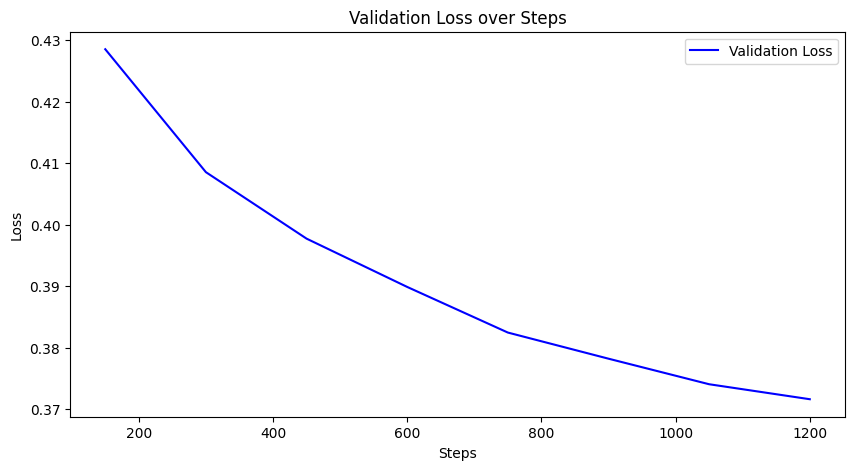

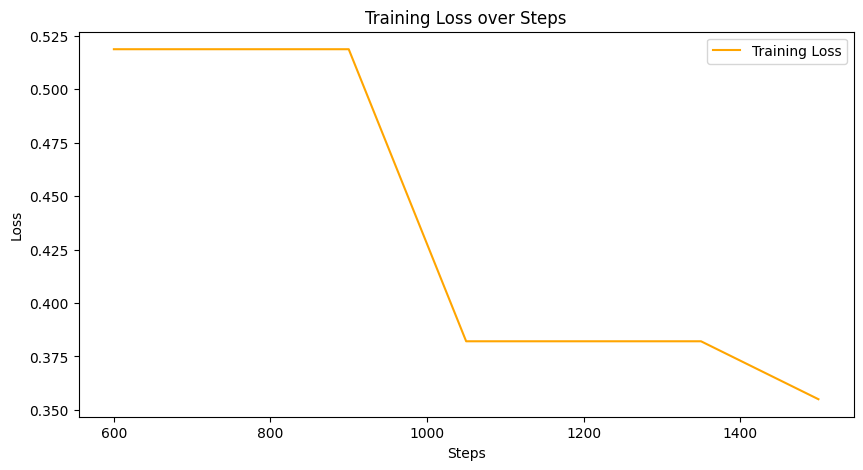

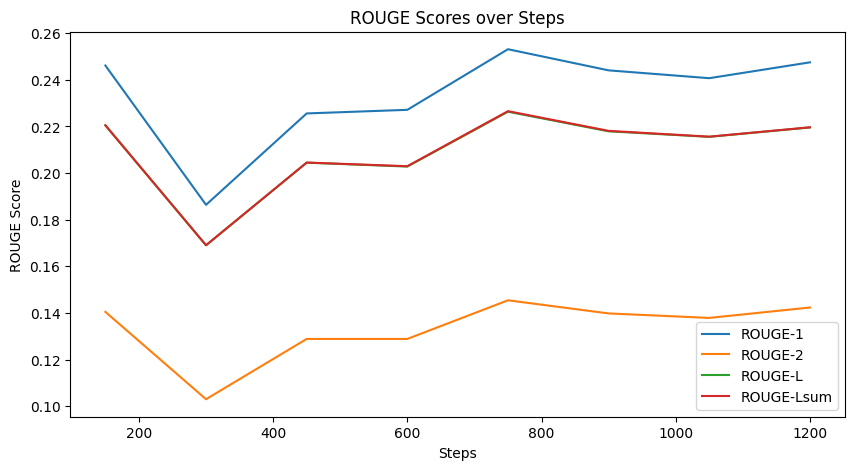

In [24]:
# Plot Evaluation Loss over Step
plt.figure(figsize=(10, 5))
plt.plot(steps, eval_losses, label='Validation Loss', color='blue')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Validation Loss over Steps')
plt.legend()
plt.show()

# Plot Training Loss over Steps
plt.figure(figsize=(10, 5))
plt.plot(training_steps, training_losses, label='Training Loss', color='orange')#, marker='o')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.legend()
plt.show()

# Plot ROUGE Scores over Steps
plt.figure(figsize=(10, 5))
if rouge1_scores:
    plt.plot(steps, rouge1_scores, label='ROUGE-1')
if rouge2_scores:
    plt.plot(steps, rouge2_scores, label='ROUGE-2')
if rougeL_scores:
    plt.plot(steps, rougeL_scores, label='ROUGE-L')
if rougeLsum_scores:
    plt.plot(steps, rougeLsum_scores, label='ROUGE-Lsum')

plt.xlabel('Steps')
plt.ylabel('ROUGE Score')
plt.title('ROUGE Scores over Steps')
plt.legend()
plt.show()

# Marged Graphs of training and validation losses

In [4]:
import json
import matplotlib.pyplot as plt

trainer_state_path = 'C:/Users/DIAL/Desktop/Jahid/Methods2TestCase-GenerationNew/checkpoint-1500/trainer_state.json'
with open(trainer_state_path, 'r') as f:
    trainer_state = json.load(f)

log_history = trainer_state['log_history']

steps = []
eval_losses = []

for log in log_history:
    if 'eval_loss' in log:
        steps.append(log['step'])
        eval_losses.append(log['eval_loss'])

manual_training_losses = {
    150: None,
    300: None,
    450: None,
    600: 0.518700,
    750: 0.518700,
    900: 0.518700,
    1050: 0.382100,
    1200: 0.382100,
    1350: 0.382100,
    1500: 0.355000
}

training_steps = list(manual_training_losses.keys())
training_losses = [loss for loss in manual_training_losses.values()]
plt.figure(figsize=(10, 5))

plt.plot(steps, eval_losses, label='Validation Loss', color='blue')
plt.plot(training_steps, training_losses, label='Training Loss', color='orange')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Steps')
plt.legend()
plt.show()

# Combined evaluation metric scores

In [ ]:
import pandas as pd
from transformers import T5ForConditionalGeneration, RobertaTokenizer
from datasets import load_dataset
import torch
import evaluate

checkpoint_folder = "C:/Users/DIAL/Desktop/Jahid/Methods2TestCase-GenerationNew/checkpoint-1500"
model = T5ForConditionalGeneration.from_pretrained(checkpoint_folder)
tokenizer = RobertaTokenizer.from_pretrained("Salesforce/codet5-base")

eval_dataset = load_dataset("csv", data_files="C:/Users/DIAL/Desktop/Jahid/eval_dataset.csv")
eval_dataset = eval_dataset['train']

total_entries = min(10000, len(eval_dataset))
step_size = 500

def preprocess_function(examples):
    return tokenizer(examples['Input'], max_length=512, truncation=True, padding="max_length")

tokenized_eval_dataset = eval_dataset.map(preprocess_function, batched=True)

# Function to generate predictions
def generate_predictions(model, dataset, tokenizer, start_idx, end_idx):
    model.eval()
    predictions = []
    
    for i in range(start_idx, end_idx):
        input_ids = dataset[i]['input_ids']
        input_ids_tensor = torch.tensor(input_ids).unsqueeze(0)  # Adding batch dimension
        
        with torch.no_grad():
            outputs = model.generate(input_ids_tensor)
        
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(prediction)
    
    return predictions

reference_texts = [item['Output'] for item in eval_dataset]

rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
chrf = evaluate.load("chrf")

# Evaluating in steps
for step in range(0, total_entries, step_size):
    start_idx = step
    end_idx = min(step + step_size, total_entries)

    print(f"Evaluating entries {start_idx + 1} to {end_idx} (Step {step // step_size + 1})")

    predictions = generate_predictions(model, tokenized_eval_dataset, tokenizer, start_idx, end_idx)

    data = {
        'Entry': [],
        'ROUGE-1': [],
        'ROUGE-2': [],
        'ROUGE-L': [],
        'ROUGE-Lsum': [],
        'CHRF': [],
        'METEOR': []
    }

    # Calculating scores for the current step
    for i in range(start_idx, end_idx):
        idx_in_step = i - start_idx  # Adjust index for current step

        # ROUGE score
        individual_rouge = rouge.compute(predictions=[predictions[idx_in_step]], references=[reference_texts[i]], use_stemmer=True)
        data['ROUGE-1'].append(individual_rouge['rouge1'])
        data['ROUGE-2'].append(individual_rouge['rouge2'])
        data['ROUGE-L'].append(individual_rouge['rougeL'])
        data['ROUGE-Lsum'].append(individual_rouge['rougeLsum'])

        # CHRF score
        individual_chrf = chrf.compute(predictions=[predictions[idx_in_step]], references=[[reference_texts[i]]])
        data['CHRF'].append(individual_chrf['score'])

        # METEOR score
        individual_meteor = meteor.compute(predictions=[predictions[idx_in_step]], references=[reference_texts[i]])
        data['METEOR'].append(individual_meteor['meteor'])

        data['Entry'].append(i + 1)

    results_df = pd.DataFrame(data)

    # Calculation of mean scores
    mean_rouge1 = results_df['ROUGE-1'].mean()
    mean_rouge2 = results_df['ROUGE-2'].mean()
    mean_rougeL = results_df['ROUGE-L'].mean()
    mean_rougeLsum = results_df['ROUGE-Lsum'].mean()
    mean_chrf = results_df['CHRF'].mean()
    mean_meteor = results_df['METEOR'].mean()

    print(f"Mean scores for Step {step // step_size + 1}:")
    print(f"ROUGE-1: {mean_rouge1}, ROUGE-2: {mean_rouge2}, ROUGE-L: {mean_rougeL}, ROUGE-Lsum: {mean_rougeLsum}, CHRF: {mean_chrf}, METEOR: {mean_meteor}")

    # saving the DataFrame for the current step
    results_df.to_csv(f"evaluation_results_1500_step_{step // step_size + 1}.csv", index=False)

print("Evaluation completed!")

# Combined Metrics Graph

In [4]:
!pip install pandas matplotlib seaborn
!pip install openpyxl

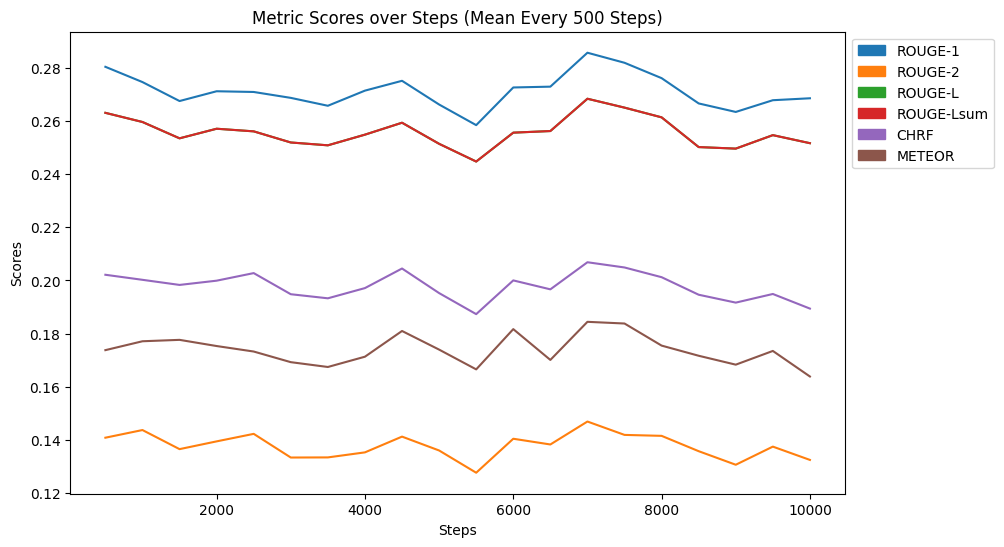

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

file_path = 'C:/Users/DIAL/Desktop/Jahid/Methods2TestCase-GenerationNew/checkpoint-1200/Combined_Metric/EvaluationMetricsScores_1200_decimal.xlsx'
df = pd.read_excel(file_path)

df.set_index('Steps', inplace=True)
plt.figure(figsize=(10, 6))

custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Blue, Orange, Green, Red, Purple, Brown

sns.lineplot(data=df, dashes=False, palette=custom_colors)

plt.title('Metric Scores over Steps (Mean Every 500 Steps)')
plt.xlabel('Steps')
plt.ylabel('Scores')
handles = [Patch(color=color, label=col) for col, color in zip(df.columns, custom_colors)]
plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

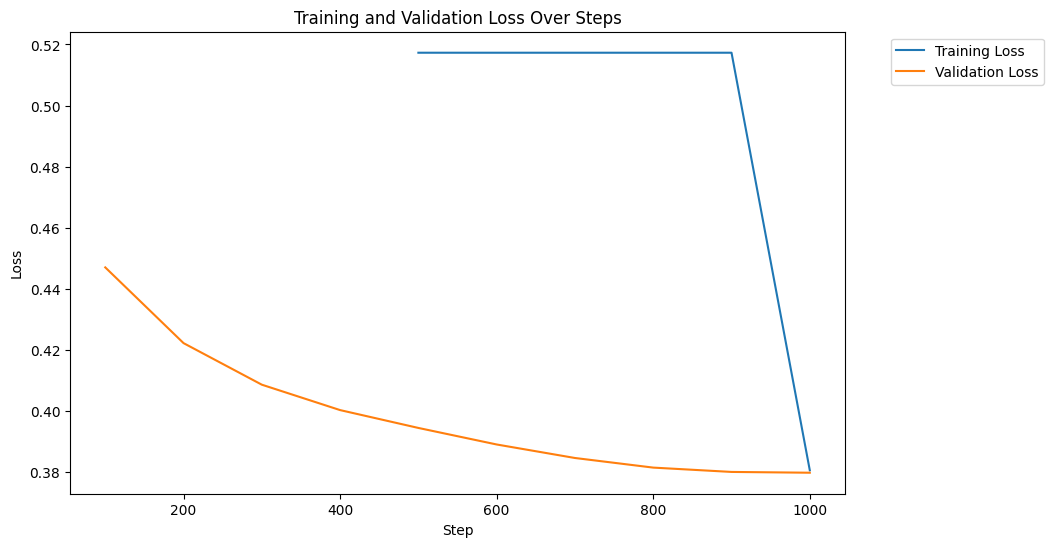

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

excel_file = 'C:/Users/DIAL/Downloads/checkpoint_1000_scores.xlsx'  # Replace with your actual file path
df = pd.read_excel(excel_file)

#print(df.head())
plt.figure(figsize=(10, 6))  # Set the figure size

# Ploting both 'Training Loss' and 'Validation Loss'
sns.lineplot(data=df, x='Step', y='Training Loss', label='Training Loss')
sns.lineplot(data=df, x='Step', y='Validation Loss', label='Validation Loss')

plt.title('Training and Validation Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
#plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.grid(True)
plt.show()


# User Interface for the model generation

In [ ]:
from transformers import T5ForConditionalGeneration, RobertaTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the tokenizer and model from the checkpoint
checkpoint_folder = "C:/Users/DIAL/Desktop/Jahid/Methods2TestCase-GenerationNew/checkpoint-1200"
model = T5ForConditionalGeneration.from_pretrained(checkpoint_folder).to(device)
tokenizer = RobertaTokenizer.from_pretrained("Salesforce/codet5-base")

In [ ]:
!pip install transformers
!pip install typing_extensions

In [ ]:
!pip install lida==0.0.4
!pip install gradio

In [ ]:
import gradio as gr
from torch.utils.data import DataLoader
import torch
def testcase(text):

    input_feature = tokenizer(text, truncation=True, max_length=1024)
    # print("a: ", input_feature)
    input_feature["input_ids"] = torch.tensor(input_feature["input_ids"])
    # print(input_feature["input_ids"])
    input_feature['input_ids'] = input_feature['input_ids'].unsqueeze(0)
    # print(input_feature["input_ids"])

    with torch.no_grad():
        preds = model.generate(
          input_feature["input_ids"].to(device),
          remove_invalid_values=True,
          generation_config=GenerationConfig(max_new_tokens=128, num_beams=10, do_sample=True, top_k=50,
                                               top_p=1.0,temperature=1, use_cache=True, output_attentions=True),

          #typical_p=1.0,
          #top_k=50,
          #top_p=1.0,
          #max_length = 128,
          length_penalty = 1.0,
          num_return_sequences=1,
          no_repeat_ngram_size=2,
        )
    text_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    return text_preds[0]


In [ ]:
interface = gr.Interface(
    fn = testcase,
    inputs =gr.Textbox(lines=10, placeholder="Enter the focal method ..."),
    outputs =gr.Textbox(lines=10, placeholder=""),
    #outputs = "text",
    title='Test Case Generation',

    description = "Flag if you find any erroneous output",
    flagging_options = ['Nice, correct testCase', 'Not correct', 'Need to improve a litte'],
    theme = 'darkpeach'
)


In [ ]:
interface.launch(auth=("Jahid", "Mjahid642"))

In [ ]:
index = 150
text_method = dataset['test'] [index] ['Input']
human_baseline_testCase = dataset['test'] [index] ['Output']

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

print("Input Method: ")
print(dataset["test"][index]["Input"])
print(f'Baseline Human Test Case:\n {human_baseline_testCase}')

In [ ]:
index = 200
text_method = dataset['test'] [index] ['Input']
human_baseline_testCase = dataset['test'] [index] ['Output']

prompt = f"""
Generate Test Case for the following method: 
{text_method}

Test Case:
"""
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

instruct_model_outputs = model.generate(
    input_ids=input_ids.to(device),
    remove_invalid_values=True,
    generation_config=GenerationConfig(max_new_tokens=512, do_sample=True, top_k=50, 
                                       top_p=1.0, typical_p=1.0, temperature=1.5, use_cache=True, output_attentions=True),
    length_penalty=1.0,
    no_repeat_ngram_size=2,
    num_return_sequences=1,
)
instruct_model_testCase_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

print("Input Method: ")
print(dataset["test"][index]["Input"])
#print(dash_line)
print(f'Baseline Human Test Case:\n {human_baseline_testCase}')
#print(dash_line)
print(f'Instruct Model Generated Test Case:\n {instruct_model_testCase_output}')